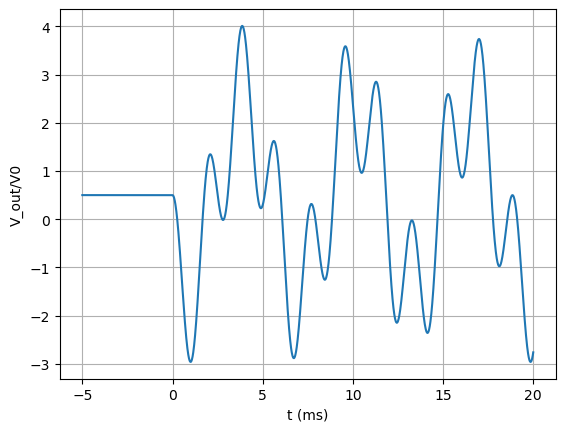

In [3]:
import numpy as np

def normalized_step_response(
    t,
    R=5.0e5,                 # Ohm
    C0=1.0e-12,              # F (baseline/vacuum capacitance of the cell) -- set to your value
    eps_inf=15.0,            # ε_∞ (dimensionless)
    eps_s=80.0,              # ε_s (dimensionless)
    tau_D=1.0e-3,            # Debye time (s)
    rho=1.0e7                # resistivity ρ (Ω·m); sigma = 1/rho
):
    """
    Compute V_out(t)/V0 for the RC+Debye dielectric model, using the compact complex form.

    Parameters
    ----------
    t : array_like
        Time array in seconds.
    R : float
        Series resistance in Ohms.
    C0 : float
        Baseline (vacuum-geometry) capacitance of the cell in Farads.
    eps_inf : float
        High-frequency dielectric constant ε_∞.
    eps_s : float
        Static dielectric constant ε_s.
    tau_D : float
        Debye relaxation time (s).
    rho : float
        Resistivity (Ω·m). Conductivity sigma = 1/rho.

    Returns
    -------
    Vout_over_V0 : ndarray
        The normalized step response V_out(t)/V0 (same shape as t).
    """
    t = np.asarray(t, dtype=float)
    H = (t > 0).astype(float)  # Heaviside (H(0)=0 here)

    # --- Physical constants
    eps0 = 8.8541878128e-12  # F/m

    # --- Conductivity and tau_sigma
    sigma = 0.0 if np.isinf(rho) else 1.0 / rho                # S/m
    tau_sigma = np.inf if sigma == 0 else eps0 / sigma         # s

    # --- Characteristic times (all have units of seconds)
    tau_inf = eps_inf * C0 * R                                 # τ_∞ = ε_∞ C0 R
    tau_1   = (eps_s - eps_inf) * C0 * R                       # τ_1 = (ε_s - ε_∞) C0 R
    tau_0   = R * C0                                           # τ_0 = R C0

    # --- Dimensionless ratios (G, G3) and change of variable u = ω τ_D
    #     G3 = τ_D/τ_∞ - j (τ_0 τ_D)/(τ_σ τ_∞)
    #     2G = 1 + τ_1/τ_∞ + τ_D/τ_∞ - j (τ_0 τ_D)/(τ_σ τ_∞)
    j = 1j
    if np.isinf(tau_sigma):
        G3 = (tau_D / tau_inf) + 0j
        twoG = 1.0 + (tau_1 / tau_inf) + (tau_D / tau_inf) + 0j
    else:
        leak = (tau_0 * tau_D) / (tau_sigma * tau_inf)
        G3 = (tau_D / tau_inf) - j * leak
        twoG = 1.0 + (tau_1 / tau_inf) + (tau_D / tau_inf) - j * leak

    G = 0.5 * twoG

    # --- Quadratic roots (dimensionless): u^2 + 2G u + G3 = (u - α1)(u - α2)
    #     α_{1,2} = -G ± sqrt(G^2 - G3)
    radical = np.sqrt(G * G - G3)  # principal branch
    alpha1 = -G + radical
    alpha2 = -G - radical

    # --- Prefactor for I(t)
    # I(t) = - [τ_D / (τ_∞ α1 α2 (α1 - α2))] H(t) * [ (α1-α2)
    #        + (α2 + j α1 α2) e^{j α1 t/τ_D} - (α1 + j α1 α2) e^{j α2 t/τ_D} ]
    denom = tau_inf * alpha1 * alpha2 * (alpha1 - alpha2)
    pref  = -(tau_D / denom)  # includes the overall minus sign

    # --- Exponentials (note the /tau_D)
    exp1 = np.exp(j * alpha1 * (t / tau_D))
    exp2 = np.exp(j * alpha2 * (t / tau_D))

    # --- Bracketed combination
    term_const = (alpha1 - alpha2)
    term_1 = (alpha2 + j * alpha1 * alpha2) * exp1
    term_2 = (alpha1 + j * alpha1 * alpha2) * exp2

    I_t = pref * H * (term_const + term_1 - term_2)

    # --- Final normalized step response: V_out/V0 = 1/2 + Im{ I(t) }
    Vout_over_V0 = 0.5 + np.imag(I_t)
    return Vout_over_V0


# ----------------- Example usage -----------------
if __name__ == "__main__":
    # Parameters from your request
    R = 5.0e5                         # Ohm
    eps_inf = 15.0
    eps_s   = 80.0
    tau_D   = 1.0e-3                  # s
    rho     = 1.0e7                   # Ω·m
    rho = np.inf 
    eps_s = eps_inf 
    C0      = 40.0e-12                 # F  <-- set to your actual cell capacitance

    # Time grid
    t = np.linspace(-5e-3, 20e-3, 2001)  # -5 ms to 20 ms

    y = normalized_step_response(t, R=R, C0=C0, eps_inf=eps_inf, eps_s=eps_s, tau_D=tau_D, rho=rho)

    # Quick check: monotonic causal behavior
    # (Plot if you like, e.g., with matplotlib)
import matplotlib.pyplot as plt
plt.plot(t*1e3, y); plt.xlabel('t (ms)'); plt.ylabel('V_out/V0'); plt.grid(True); plt.show()


In [5]:
import numpy as np

EPS0 = 8.8541878128e-12

def our_poles(R, C0, eps_inf, eps_s, tau_D, rho=np.inf):
    """Return Laplace poles s1,s2 using our α1,α2 derivation."""
    # Characteristic times
    tau_inf = eps_inf * C0 * R
    tau_1   = (eps_s - eps_inf) * C0 * R
    tau_0   = R * C0

    # Conductivity/resistivity
    if np.isinf(rho):
        leak = 0.0
    else:
        tau_sigma = EPS0 * rho
        leak = (tau_0 * tau_D) / (tau_sigma * tau_inf)

    # Dimensionless ratios
    G3 = (tau_D / tau_inf) - 1j * leak
    twoG = 1.0 + (tau_1 / tau_inf) + (tau_D / tau_inf) - 1j * leak
    G = 0.5 * twoG

    # Roots
    radical = np.sqrt(G*G - G3)
    alpha1 = -G + radical
    alpha2 = -G - radical

    # Map to Laplace poles
    s1 = 1j * alpha1 / tau_D
    s2 = 1j * alpha2 / tau_D
    return s1, s2

def their_poles(R, C0, k_inf, Delta_k, tau, rho=None):
    C_inf = k_inf * C0
    dC    = Delta_k * C0
    G = 0.0 if (rho is None or not np.isfinite(rho) or rho <= 0.0) else C0/(rho*EPS0)

    a = R * C_inf * tau
    b = tau * (1.0 + R * G) + R * (C_inf + dC)
    c = 1.0 + R * G

    disc = b*b - 4.0*a*c
    sqrt_disc = np.sqrt(disc + 0j)   # allow complex roots
    s1 = (-b + sqrt_disc) / (2.0 * a)
    s2 = (-b - sqrt_disc) / (2.0 * a)
    return s1, s2

R = 5.0e5
C0 = 40e-12
eps_inf = 15.0
eps_s   = 80.0
tau_D   = 1.0e-3
rho     = 1.0e7

s1_ours, s2_ours = our_poles(R, C0, eps_inf, eps_s, tau_D, rho)
s1_theirs, s2_theirs = their_poles(R, C0, eps_inf, eps_s-eps_inf, tau_D, rho)

print("Our poles:   ", s1_ours, s2_ours)
print("Their poles: ", s1_theirs, s2_theirs)



Our poles:    (-56.743100759967135-408.4205815741062j) (-696.1962774887122-8258.246085092562j)
Their poles:  (-455.8669864118305+0j) (-8963.739058503515+0j)


Laplace poles: -455.8669863791982 -8963.739058025922
FT poles:      (-8963.739058025923+0j) (-455.86698637919733+0j)
0.40786966125455026
True


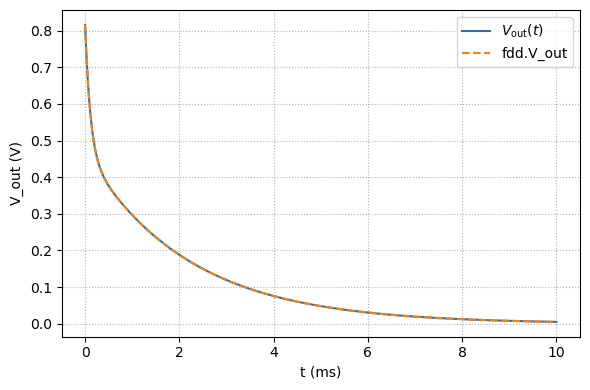

: 

In [ ]:
import numpy as np
import scipy.constants as scc
from numpy.lib.scimath import sqrt

def laplace_poles(R, C0, eps_inf, eps_s, tau_D, rho):
    eps0 = scc.epsilon_0
    G = 0.0 if (rho is None or rho<=0 or not np.isfinite(rho)) else C0/(rho*eps0)
    C_inf = eps_inf*C0
    dC    = (eps_s - eps_inf)*C0
    a = R*C_inf*tau_D
    b = tau_D*(1 + R*G) + R*(C_inf + dC)
    c = 1 + R*G
    disc = b*b - 4*a*c
    s1 = (-b + sqrt(disc)) / (2*a)
    s2 = (-b - sqrt(disc)) / (2*a)
    return s1, s2

def ft_poles(R, C0, eps_inf, eps_s, tau_D, rho):
    eps0 = scc.epsilon_0
    tau_sigma = np.inf if (rho is None or rho<=0 or not np.isfinite(rho)) else eps0/(1.0/rho)
    tau_inf = eps_inf*C0*R
    tau1    = (eps_s - eps_inf)*C0*R
    tau0    = R*C0
    # ---- corrected definitions ----
    G3   = (tau_D/tau_inf) * (1.0 + tau0/tau_sigma)
    twoG = 1.0 + (tau1 + tau_D)/tau_inf + (tau_D*tau0)/(tau_sigma*tau_inf)
    # --------------------------------
    # roots in u-plane, then map to s-plane via s = j*u / tau_D
    disc  = -(twoG**2) + 4.0*G3
    alpha1 = 0.5*(1j*twoG + sqrt(disc))
    alpha2 = 0.5*(1j*twoG - sqrt(disc))
    s1 = 1j*alpha1 / tau_D
    s2 = 1j*alpha2 / tau_D
    return s1, s2

# example params
R, C0, eps_inf, eps_s, tau_D, rho = 0.5e6, 40e-12, 15.0, 80.0, 1e-3, 1e7
print("Laplace poles:", *laplace_poles(R,C0,eps_inf,eps_s,tau_D,rho))
print("FT poles:     ", *ft_poles(R,C0,eps_inf,eps_s,tau_D,rho))


# Example usage
from matplotlib import pyplot as plt
from py_dielectric_spectroscopy import fit_dielectric_data as fdd
if __name__ == "__main__":
    t = np.linspace(0, 0.01, 1000)  # 0 to 10 ms
    Vout = V_out(t)
    Vold = fdd.V_debye_sigma_falling_edge(t, R=5e5, C0=40e-12, k_inf=15.0, Delta_k=80.0-15, tau=1e-3, rho=1e7)
    print(np.allclose(Vout, Vold))
    plt.figure(figsize=(6,4))
    plt.plot(t*1e3, Vout, label=r"$V_{\rm out}(t)$")
    plt.plot(t*1e3, Vold, '--', label='fdd.V_out')
    plt.xlabel("t (ms)")
    plt.ylabel("V_out (V)")
    plt.grid(True, ls=":")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
from numpy.lib.scimath import sqrt  # complex-safe sqrt

def V_out(t, V0=1.0,
          tau_D=1e-3,
          C0=40e-12,
          R=0.5e6,
          eps_inf=15.0,
          eps_s=80.0,
          rho=1e7):  # Ohm·m; sigma = 1/rho
    """
    Step response V_out(t) for RC load with Debye dielectric (causal, PV dropped).

    Parameters
    ----------
    t : ndarray
        Time array [s].
    V0 : float
        Input square-wave step amplitude (use 1.0 for normalized).
    tau_D : float
        Debye relaxation time [s].
    C0 : float
        Vacuum (geometric) capacitance of the cell [F].
    R : float
        Series resistance [Ohm].
    eps_inf : float
        High-frequency dielectric constant.
    eps_s : float
        Static dielectric constant.
    rho : float
        Resistivity [Ohm·m] (sigma = 1/rho).

    Returns
    -------
    Vout : ndarray
        Output voltage vs time.
    """
    t = np.asarray(t)
    H = (t >= 0).astype(float)  # Heaviside for causality

    eps0 = 8.8541878128e-12
    sigma = 1.0 / rho

    # Characteristic times
    tau_inf  = eps_inf * C0 * R
    tau1     = (eps_s - eps_inf) * C0 * R
    tau0     = R * C0
    tau_sigma = eps0 / sigma

    # Dimensionless groups
    G3   = (tau_D / tau_inf) * (1.0 + tau0 / tau_sigma)
    twoG = 1.0 + (tau1 + tau_D) / tau_inf + (tau_D * tau0) / (tau_sigma * tau_inf)

    # Poles in u-plane
    disc   = -(twoG**2) + 4.0 * G3
    alpha1 = 0.5 * (1j * twoG + sqrt(disc))
    alpha2 = 0.5 * (1j * twoG - sqrt(disc))

    # Residue coefficients
    B = (1.0 + 1j * alpha1) / (alpha1 * (alpha1 - alpha2))
    C = (1.0 + 1j * alpha2) / (alpha2 * (alpha2 - alpha1))

    xi = t / tau_D
    term_const = -1.0 / (2.0 * G3)                           # constant from u=0 pole
    term_dyn   = B * np.exp(1j * alpha1 * xi) + C * np.exp(1j * alpha2 * xi)

    I_t = (tau_D / tau_inf) * H * np.real(term_const + term_dyn)

    return V0 * (I_t[0] + I_t)


In [1]:
import numpy as np
import scipy.constants as scc
from numpy.lib.scimath import sqrt  # complex-safe sqrt

def laplace_poles(R, C0, eps_inf, eps_s, tau_D, rho=None):
    """Compute poles using Laplace-domain quadratic (working code style)."""
    eps0 = scc.epsilon_0
    if rho is None or not np.isfinite(rho) or rho <= 0:
        G = 0.0
    else:
        G = C0 / (rho * eps0)

    C_inf = eps_inf * C0
    dC    = (eps_s - eps_inf) * C0

    a = R * C_inf * tau_D
    b = tau_D * (1.0 + R*G) + R * (C_inf + dC)
    c = 1.0 + R*G

    disc = b*b - 4.0*a*c
    sqrt_disc = sqrt(disc)

    s1 = (-b + sqrt_disc) / (2.0*a)
    s2 = (-b - sqrt_disc) / (2.0*a)
    return s1, s2


def ft_poles(R, C0, eps_inf, eps_s, tau_D, rho=None):
    """Compute poles from Fourier-transform dimensionless form, mapped to s-plane."""
    eps0 = scc.epsilon_0
    if rho is None or not np.isfinite(rho) or rho <= 0:
        tau_sigma = np.inf
    else:
        tau_sigma = eps0 / (1.0/rho)

    tau_inf = eps_inf * C0 * R
    tau1    = (eps_s - eps_inf) * C0 * R
    tau0    = R * C0

    G3   = (tau_D/tau_inf) * (1.0 + tau0/tau_sigma)
    twoG = 1.0 + tau1/tau_inf + tau_D/tau_inf + (tau_D*tau0)/(tau_sigma*tau_inf)

    disc = -(twoG**2) + 4.0*G3
    alpha1 = 0.5*(1j*twoG + sqrt(disc))
    alpha2 = 0.5*(1j*twoG - sqrt(disc))

    # Map to s-plane
    s1 = alpha1 / tau_D
    s2 = alpha2 / tau_D
    return s1, s2


# --- Example with your parameters ---
R       = 0.5e6
C0      = 40e-12
eps_inf = 15
eps_s   = 80
tau_D   = 1e-3
rho     = 1e7

s1_lap, s2_lap = laplace_poles(R, C0, eps_inf, eps_s, tau_D, rho)
s1_ft,  s2_ft  = ft_poles(R, C0, eps_inf, eps_s, tau_D, rho)

print("Laplace poles:", s1_lap, s2_lap)
print("FT poles:     ", s1_ft, s2_ft)


Laplace poles: -455.8669863791982 -8963.739058025922
FT poles:      8963.739058025923j 455.86698637919733j
